# Create Dataset

download dataset from https://datasetninja.com/gc10-det <br>
(or use the attached file named with "eyJsaW")  <br>
unzip <br>
put the folder 'dc' under DAMO-YOLO/datasets/ <br>
and rename it as 'GC10-Det'

refer to official tutorial https://github.com/tinyvision/DAMO-YOLO/blob/master/assets/CustomDatasetTutorial.md

the dataset should be in coco format saved in json, includes three necessary feilds, i.e., image, annotation, categories. Here is an example

In [5]:
%cd DAMO-YOLO

/home/test/DAMO-YOLO


In [10]:
# Now we convert the json into 
import os
import json
import random
from collections import Counter

def unify_json_files_with_split(json_directory, train_ratio=0.8):
    """
    Unify multiple JSON annotation files into train and test sets
    and report all unique class titles with their counts.
    
    Args:
        json_directory (str): Path to directory containing JSON files
        train_ratio (float): Ratio of files to use for training (0.0-1.0)
    
    Returns:
        dict: Training data
        dict: Testing data
        Counter: Class counts
    """
    # List all JSON files in the directory
    json_files = [f for f in os.listdir(json_directory) if f.endswith('.json')]
    print(f"Found {len(json_files)} JSON files")
    
    # Shuffle and split the files
    random.shuffle(json_files)
    split_idx = int(len(json_files) * train_ratio)
    train_files = json_files[:split_idx]
    test_files = json_files[split_idx:]
    
    print(f"Split: {len(train_files)} training files, {len(test_files)} testing files")
    
    # Initialize data structures
    train_data = {"images": [], "annotations": [], "categories": []}
    test_data = {"images": [], "annotations": [], "categories": []}
    
    class_titles = Counter()
    class_mapping = {}  # Maps classId to classTitle
    
    # Process train and test sets separately
    for is_train, file_list in [(True, train_files), (False, test_files)]:
        data_dict = train_data if is_train else test_data
        next_image_id = 0
        next_annotation_id = 0
        
        for json_filename in file_list:
            json_path = os.path.join(json_directory, json_filename)
            
            with open(json_path, 'r') as file:
                try:
                    data = json.load(file)
                    
                    # Create an image entry
                    image_info = {
                        "id": next_image_id,
                        "file_name": json_filename.replace('.json', ''),
                        "height": data.get("size", {}).get("height", 0),
                        "width": data.get("size", {}).get("width", 0)
                    }
                    data_dict["images"].append(image_info)
                    
                    # Process all objects/annotations
                    if "objects" in data:
                        for obj in data["objects"]:
                            # Extract class information
                            class_title = obj.get("classTitle", "unknown")
                            class_id = obj.get("classId", -1)
                            
                            # Track classes
                            class_titles[class_title] += 1
                            class_mapping[class_id] = class_title
                            
                            # Create annotation entry
                            points = obj.get("points", {})
                            exterior = points.get("exterior", [])
                            
                            # Calculate bounding box from exterior points
                            if exterior:
                                x_coords = [p[0] for p in exterior]
                                y_coords = [p[1] for p in exterior]
                                x_min = min(x_coords)
                                y_min = min(y_coords)
                                width = max(x_coords) - x_min
                                height = max(y_coords) - y_min
                                
                                annotation = {
                                    "id": next_annotation_id,
                                    "image_id": next_image_id,
                                    "category_id": class_id,
                                    "category_name": class_title,
                                    "bbox": [x_min, y_min, width, height],
                                    "area": width * height,
                                    "segmentation": [sum([[p[0], p[1]] for p in exterior], [])],
                                    "iscrowd": 0,
                                    "geometry_type": obj.get("geometryType", "")
                                }
                                
                                data_dict["annotations"].append(annotation)
                                next_annotation_id += 1
                    
                    next_image_id += 1
                    
                except json.JSONDecodeError:
                    print(f"Error decoding JSON from {json_filename}")
    
    # Add categories to both train and test data
    categories = [
        {"id": class_id, "name": class_title}
        for class_id, class_title in class_mapping.items()
    ]
    train_data["categories"] = categories
    test_data["categories"] = categories
        
    return train_data, test_data, class_titles

# Directory containing JSON files
json_directory = "./datasets/GC10-Det/ann"  # change directory
train_ratio = 0.8  # 80% for training, 20% for testing

# Set random seed for reproducibility
random.seed(42)

# Unify JSON files with train-test split
train_data, test_data, class_counts = unify_json_files_with_split(json_directory, train_ratio)

# Save unified data
train_output_path = os.path.join(json_directory, "train_annotations.json")
test_output_path = os.path.join(json_directory, "test_annotations.json")

with open(train_output_path, 'w') as f:
    json.dump(train_data, f, indent=2)

with open(test_output_path, 'w') as f:
    json.dump(test_data, f, indent=2)
       
# Report statistics
print(f"\nTrain annotations saved to {train_output_path}")
print(f"Test annotations saved to {test_output_path}")

print(f"\nTraining set: {len(train_data['images'])} images, {len(train_data['annotations'])} annotations")
print(f"Testing set: {len(test_data['images'])} images, {len(test_data['annotations'])} annotations")

# Report class statistics
print("\nClass distribution:")
for class_name, count in class_counts.most_common():
    print(f"  {class_name}: {count} instances")

Found 2302 JSON files
Split: 1841 training files, 461 testing files

Train annotations saved to ./datasets/GC10-Det/ann/train_annotations.json
Test annotations saved to ./datasets/GC10-Det/ann/test_annotations.json

Training set: 1841 images, 2875 annotations
Testing set: 461 images, 688 annotations

Class distribution:
  silk_spot: 884 instances
  oil_spot: 569 instances
  welding_line: 513 instances
  water_spot: 354 instances
  inclusion: 347 instances
  punching_hole: 329 instances
  crescent_gap: 265 instances
  waist folding: 143 instances
  rolled_pit: 85 instances
  crease: 74 instances


In [2]:
def remap_category_ids(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Sort categories by name for consistent remapping
    sorted_categories = sorted(data["categories"], key=lambda x: x["name"])

    # Create new ID mapping (old_id -> new_id)
    old_to_new = {cat["id"]: new_id for new_id, cat in enumerate(sorted_categories)}

    # Update category entries
    new_categories = [
        {"id": new_id, "name": cat["name"]}
        for cat, new_id in zip(sorted_categories, range(len(sorted_categories)))
    ]

    # Update annotations
    for ann in data["annotations"]:
        ann["category_id"] = old_to_new[ann["category_id"]]

    # Save back
    data["categories"] = new_categories
    with open(json_path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Remapped category IDs in: {json_path}")
    names = [cat['name'] for cat in new_categories]
    print('categories:')
    print(names)

# Apply remapping
remap_category_ids(train_output_path)
remap_category_ids(test_output_path)

Remapped category IDs in: ./datasets/GC10-Det/ann/train_annotations.json
categories:
['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot', 'waist folding', 'water_spot', 'welding_line']
Remapped category IDs in: ./datasets/GC10-Det/ann/test_annotations.json
categories:
['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot', 'waist folding', 'water_spot', 'welding_line']


In [3]:
# Define new folder structure to allocate them in train and valid folder
import shutil
base_dir = "./datasets/GC10-Det"
image_source_dir = os.path.join(base_dir, "img")
ann_source_dir = os.path.join(base_dir, "ann")

# Target directories
dirs_to_create = [
    os.path.join(base_dir, "train", "img"),
    os.path.join(base_dir, "train", "ann"),
    os.path.join(base_dir, "valid", "img"),
    os.path.join(base_dir, "valid", "ann")
]

# Create necessary folders
for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)

def move_files(image_list, split_name):
    img_target = os.path.join(base_dir, split_name, "img")
    
    for image in image_list:
        base_name = image["file_name"]

        # Move image file (try common extensions)
        src_img_path = os.path.join(image_source_dir, base_name)
        if os.path.exists(src_img_path):
            shutil.copy(src_img_path, os.path.join(img_target, base_name))
        else:
            print(f"Image not found for: {base_name}")

# Move train and valid files
move_files(train_data["images"], "train")
move_files(test_data["images"], "valid")

shutil.move(train_output_path, os.path.join(dirs_to_create[1], "annotations.json"))
shutil.move(test_output_path, os.path.join(dirs_to_create[3], "annotations.json"))

print(f"\nMoved images and annotations to 'train' and 'valid' folders.")

try:
    shutil.rmtree(image_source_dir)
    print(f"Deleted original image directory: {image_source_dir}")
except OSError as e:
    print(f"Error deleting {img_source_dir}: {e.strerror}")

try:
    shutil.rmtree(ann_source_dir)
    print(f"Deleted original annotation directory: {ann_source_dir}")
except OSError as e:
    print(f"Error deleting {ann_source_dir}: {e.strerror}")


Moved images and annotations to 'train' and 'valid' folders.
Deleted original image directory: ./datasets/GC10-Det/img
Deleted original annotation directory: ./datasets/GC10-Det/ann


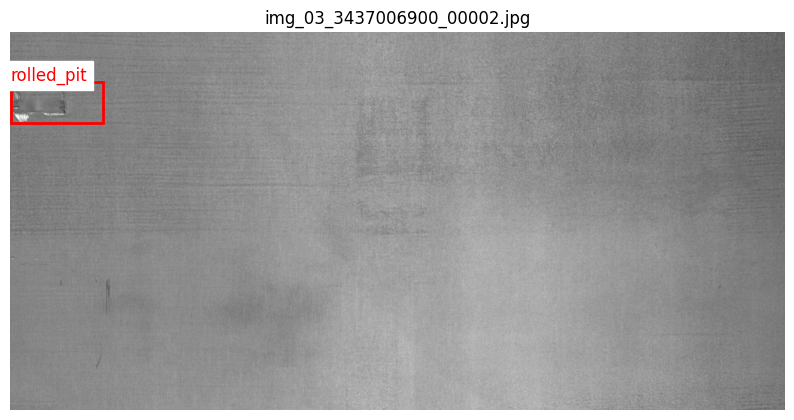

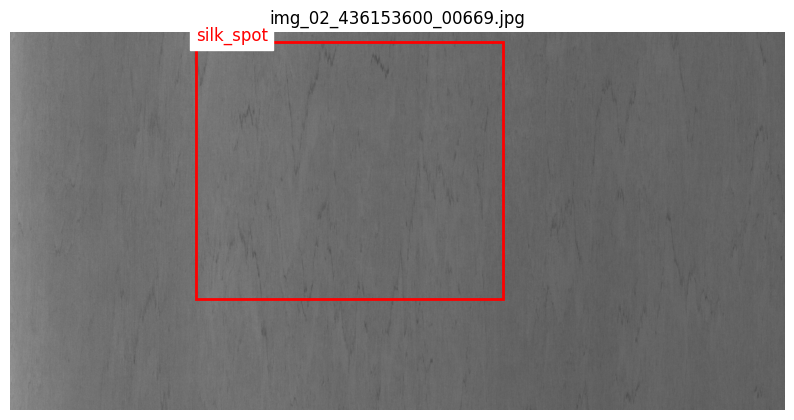

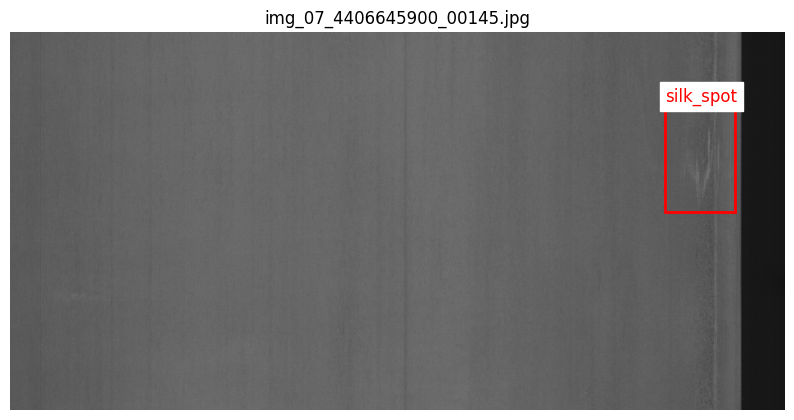

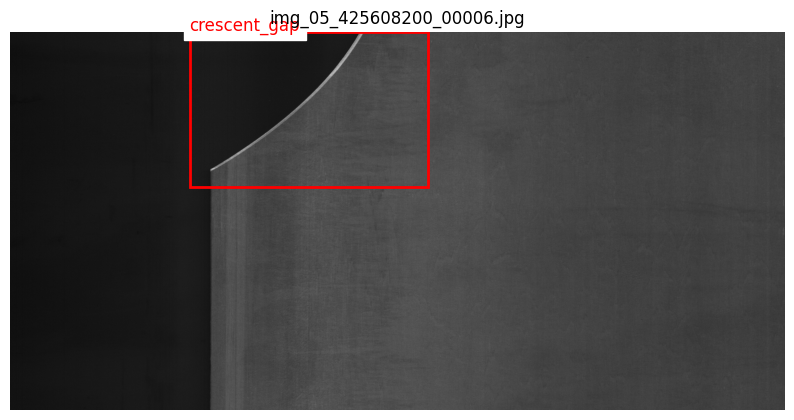

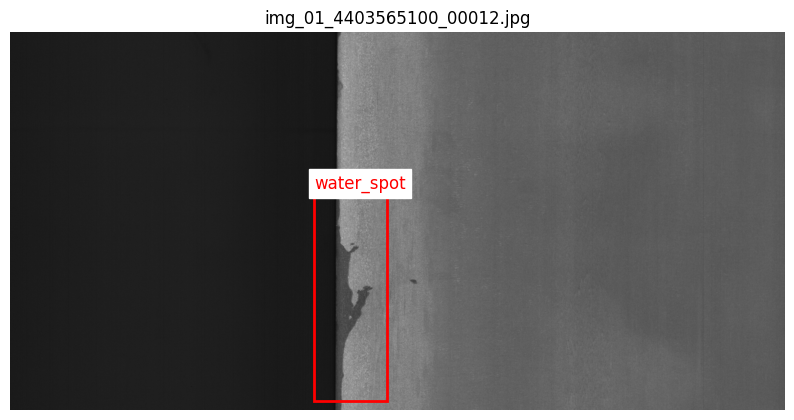

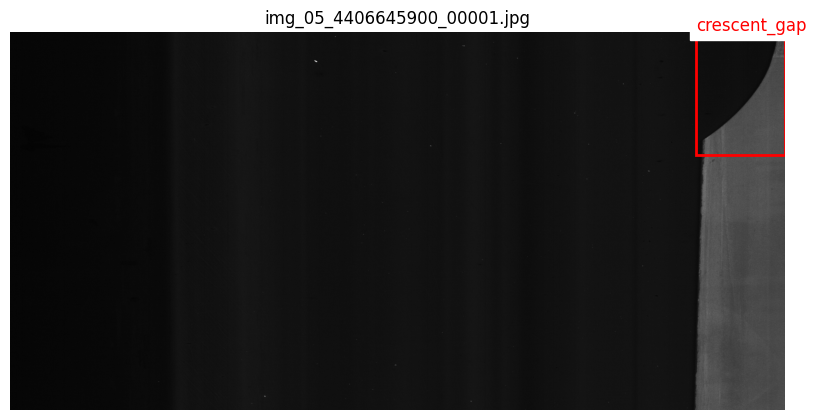

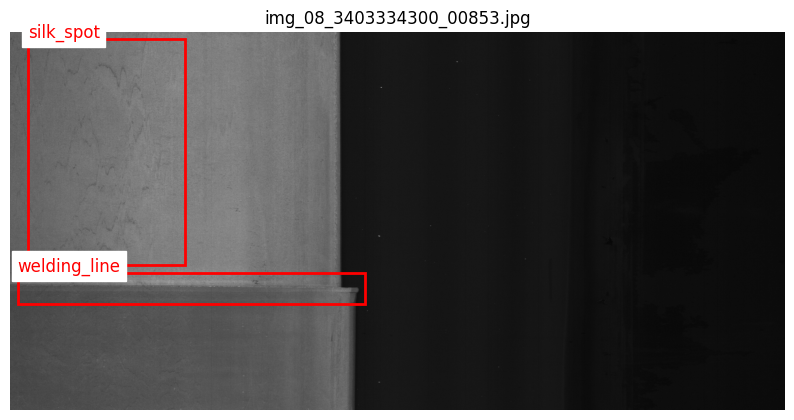

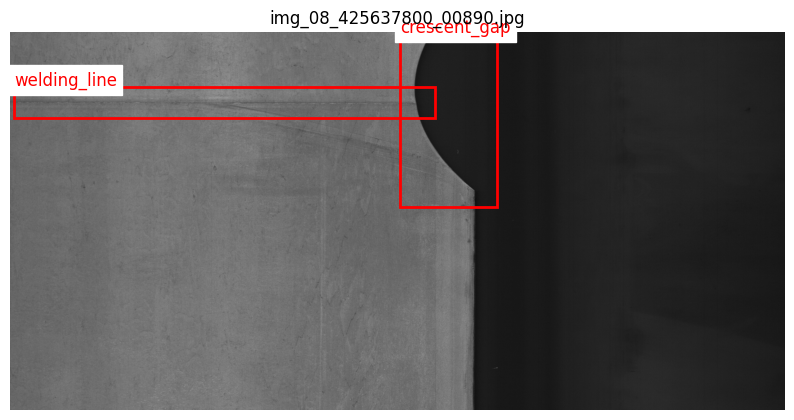

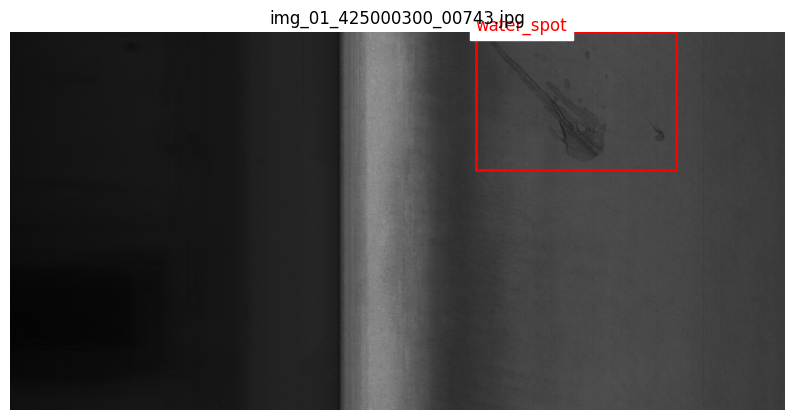

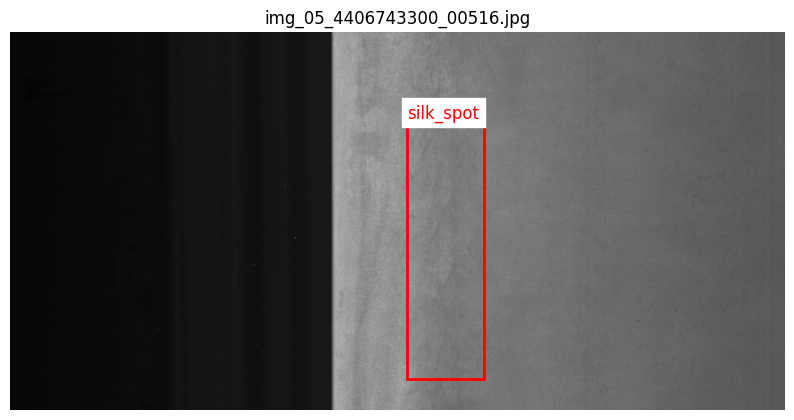

In [5]:
# plot some samples
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot(image_dir, annotation_path, num_images=10):
    # Load COCO-style JSON
    with open(annotation_path, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']
    categories = {cat['id']: cat['name'] for cat in data['categories']}

    # Map image_id -> list of annotations
    ann_map = {}
    for ann in annotations:
        ann_map.setdefault(ann['image_id'], []).append(ann)

    # Randomly sample images
    sample_images = random.sample(images, min(num_images, len(images)))

    # Plot
    for img_meta in sample_images:
        img_path = os.path.join(image_dir, img_meta['file_name'])
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        img = Image.open(img_path).convert("RGB")
        fig, ax = plt.subplots(1, figsize=(10, 8))
        ax.imshow(img)
        ax.set_title(img_meta['file_name'])

        # Draw boxes if available
        anns = ann_map.get(img_meta['id'], [])
        for ann in anns:
            bbox = ann['bbox']
            category_id = ann['category_id']
            label = categories.get(category_id, 'unknown')

            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(
                bbox[0], bbox[1] - 5, label,
                fontsize=12, color='red', backgroundcolor='white'
            )

        plt.axis('off')
        plt.show()

# Example usage:
plot(
    image_dir='datasets/GC10-Det/train/img',
    annotation_path='datasets/GC10-Det/train/ann/annotations.json',
    num_images=10
)

# Training

Please open damo/config/paths_catalog.py to revise the directory of images and annotation json <br>
Or run the below code to assign directory for our demo dataset

In [6]:
config = """
import os

class DatasetCatalog(object):
    DATA_DIR = 'datasets'
    DATASETS = {
        'coco_2017_train': {
            'img_dir': 'GC10-Det/train/img', # image directory
            'ann_file': 'GC10-Det/train/ann/annotations.json' # annotation json directory
        },
        'coco_2017_val': {
            'img_dir': 'GC10-Det/valid/img', # image directory
            'ann_file': 'GC10-Det/valid/ann/annotations.json' # annotation json directory
        },
        }

    @staticmethod
    def get(name):
        if 'coco' in name:
            data_dir = DatasetCatalog.DATA_DIR
            attrs = DatasetCatalog.DATASETS[name]
            args = dict(
                root=os.path.join(data_dir, attrs['img_dir']),
                ann_file=os.path.join(data_dir, attrs['ann_file']),
            )
            return dict(
                factory='COCODataset',
                args=args,
            )
        else:
            raise RuntimeError('Only support coco format now!')
        return None
"""
with open('./damo/config/paths_catalog.py', 'w') as f:
    f.write(config)

Please create a copy of configs/damoyolo_tinynasL18_Ns.py and name it as damoyolo_tinynasL18_Ns-GC10.py <br>
Make these changes <br>
line 17: self.train.batch_size #fit in 1 gpu <br>
line 77: 'num_classes': <br>
line 89: self.dataset.class_names  <br>
Or run the below code to finish the adjustment for our demo dataset

In [ ]:
config = """
#!/usr/bin/env python3

import os

from damo.config import Config as MyConfig


class Config(MyConfig):
    def __init__(self):
        super(Config, self).__init__()

        self.miscs.exp_name = os.path.split(
            os.path.realpath(__file__))[1].split('.')[0]
        self.miscs.eval_interval_epochs = 10
        self.miscs.ckpt_interval_epochs = 10
        # optimizer
        self.train.batch_size = 128
        self.train.base_lr_per_img = 0.001 / 64
        self.train.min_lr_ratio = 0.05
        self.train.no_aug_epochs = 16
        self.train.warmup_epochs = 5

        self.train.optimizer = {
            'name': "AdamW",
            'weight_decay': 1e-2,
            'lr': 4e-3,
            }

        # augment
        self.train.augment.transform.image_max_range = (416, 416)
        self.train.augment.transform.keep_ratio = False
        self.test.augment.transform.keep_ratio = False
        self.test.augment.transform.image_max_range = (416, 416)
        self.train.augment.mosaic_mixup.mixup_prob = 0.15
        self.train.augment.mosaic_mixup.degrees = 10.0
        self.train.augment.mosaic_mixup.translate = 0.2
        self.train.augment.mosaic_mixup.shear = 0.2
        self.train.augment.mosaic_mixup.mosaic_scale = (0.75, 1.25)
        self.train.augment.mosaic_mixup.keep_ratio = False

        self.dataset.train_ann = ('coco_2017_train', )
        self.dataset.val_ann = ('coco_2017_val', )

        # backbone
        structure = self.read_structure(
            './damo/base_models/backbones/nas_backbones/tinynas_nano_small.txt')
        TinyNAS = {
            'name': 'TinyNAS_mob',
            'net_structure_str': structure,
            'out_indices': (2, 4, 5),
            'with_spp': True,
            'use_focus': False,
            'act': 'silu',
            'reparam': False,
            'depthwise': True,
            'use_se': False,
        }

        self.model.backbone = TinyNAS

        GiraffeNeckV2 = {
            'name': 'GiraffeNeckV2',
            'depth': 0.50,
            'hidden_ratio': 0.5, # 0.5
            'in_channels': [40, 80, 160],
            'out_channels': [40, 80, 160],
            'act': 'silu',
            'spp': False,
            'block_name': 'BasicBlock_3x3_Reverse',
            'depthwise': True,
        }

        self.model.neck = GiraffeNeckV2

        ZeroHead = {
            'name': 'ZeroHead',
            'num_classes': 10,
            'in_channels': [40, 80, 160],
            'stacked_convs': 0,
            'reg_max': 7,
            'act': 'silu',
            'nms_conf_thre': 0.03,
            'nms_iou_thre': 0.65,
            'legacy': False,
            'last_kernel_size': 1,
        }
        self.model.head = ZeroHead

        self.dataset.class_names = ['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot', 'waist folding', 'water_spot', 'welding_line']
"""
with open('./configs/damoyolo_tinynasL18_Ns-GC10.py', 'w') as f:
    f.write(config)

In most case you can stick to have images reshaped to square. <br>
But you can train the model in rectangle images if you want <br>
Let say we set target_size = (288,608), meaning that we shrink the image to height=288 and width=608. The number must be divisible by 32. <br>
Go to damo/dataset/transforms/build.py <br>
revise line 23 to be <br>
        T.Resize(image_max_range, keep_ratio=keep_ratio, target_size=(288, 608)), <br>


In [7]:
# Train in only one gpu
import os
import argparse
import torch
from loguru import logger
from damo.apis import Trainer
from damo.config.base import parse_config
from damo.utils import synchronize
os.environ['MASTER_ADDR'] = 'localhost' 
os.environ['MASTER_PORT'] = '29000'
def train_damo(config_file, num_gpus=1, tea_config=None, tea_ckpt=None, opts=None):
    """
    Run DAMO-YOLO training in JupyterLab
    
    Args:
        config_file (str): Path to the config file
        num_gpus (int): Number of GPUs to use
        tea_config (str, optional): Path to teacher config file
        tea_ckpt (str, optional): Path to teacher checkpoint
        opts (list, optional): Additional configuration options
    """
    # Initialize process group
    torch.distributed.init_process_group(
        backend='nccl',
        init_method='env://',
        world_size=num_gpus,
        rank=0
    )
    
    # Set device
    torch.cuda.set_device(0)
    synchronize()
    
    # Parse configs
    if tea_config is not None:
        tea_config = parse_config(tea_config)
    
    config = parse_config(config_file)
    if opts:
        config.merge(opts)
    
    # Create args object
    args = argparse.Namespace(
        config_file=config_file,
        local_rank=0,
        tea_config=tea_config,
        tea_ckpt=tea_ckpt,
        opts=opts if opts else []
    )
    
    # Initialize trainer and start training
    trainer = Trainer(config, args, tea_config)
    trainer.train(args.local_rank)
    
    # Cleanup
    torch.distributed.destroy_process_group()

train_damo(
    config_file='configs/damoyolo_tinynasL18_Ns-GC10.py',
    num_gpus=1
)

2025-05-07 16:30:17 | INFO     | damo.apis.detector_trainer:118 - args info: Namespace(config_file='configs/damoyolo_tinynasL18_Ns-GC10.py', local_rank=0, tea_config=None, tea_ckpt=None, opts=[])
2025-05-07 16:30:17 | INFO     | damo.apis.detector_trainer:119 - cfg value:
╒═════════╤══════════════════════════════════════════════════════════════════════════════════╕
│ keys    │ values                                                                           │
╞═════════╪══════════════════════════════════════════════════════════════════════════════════╡
│ model   │ {'backbone': {'act': 'silu',                                                     │
│         │               'depthwise': True,                                                 │
│         │               'name': 'TinyNAS_mob',                                             │
│         │               'net_structure_str': "[ {'class': 'ConvKXBNRELU', 'in': 3, 'k': "  │
│         │                                    "3, 'nbitsA': 8

/home/test/DAMO-YOLO/damo/apis/detector_trainer.py:372: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  outputs_array = {_name: _v.item() for _name, _v in outputs.items()}
/opt/miniconda3/envs/py10damo/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/miniconda3/envs/py10damo/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[att

2025-05-07 16:31:40 | INFO     | damo.apis.detector_trainer:411 - epoch: 4/300, iter: 5/15, mem: 23305Mb, iter_time: 1.219s, model_time: 0.331s, total_loss: 2.3, loss_cls: 0.5, loss_bbox: 1.3, loss_dfl: 0.5, lr: 8.537e-04, size: (416, 416), ETA: 1:30:23
2025-05-07 16:32:39 | INFO     | damo.apis.detector_trainer:411 - epoch: 7/300, iter: 10/15, mem: 23305Mb, iter_time: 1.173s, model_time: 0.317s, total_loss: 1.9, loss_cls: 0.5, loss_bbox: 1.0, loss_dfl: 0.4, lr: 2.000e-03, size: (416, 416), ETA: 1:27:42
2025-05-07 16:33:38 | INFO     | damo.apis.detector_trainer:411 - epoch: 10/300, iter: 0/15, mem: 23305Mb, iter_time: 1.172s, model_time: 0.311s, total_loss: 1.6, loss_cls: 0.5, loss_bbox: 0.8, loss_dfl: 0.3, lr: 1.999e-03, size: (416, 416), ETA: 1:26:07
2025-05-07 16:33:38 | INFO     | damo.apis.detector_trainer:442 - Save weights to ./workdirs/damoyolo_tinynasL18_Ns-GC10
2025-05-07 16:33:38 | INFO     | damo.apis.detector_inference:75 - Start evaluation on coco_2017_val dataset(460 im

100%|##########| 4/4 [00:02<00:00,  1.93it/s]


2025-05-07 16:33:40 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.097483 (0.0045597454775934635 s / img per device, on 1 devices)
2025-05-07 16:33:40 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.410216 (0.0008917730787526006 s / img per device, on 1 devices)
2025-05-07 16:33:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 16:33:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 16:33:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 16:33:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 16:33:42 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.72s)
2025-05-07 16:33:42 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 16:33:42 | INFO     | pycocotools.coco:

 75%|#######5  | 3/4 [00:02<00:00,  1.94it/s]

2025-05-07 16:36:31 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.214557 (0.004814254719278087 s / img per device, on 1 devices)
2025-05-07 16:36:31 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.477216 (0.0010374255802320397 s / img per device, on 1 devices)
2025-05-07 16:36:31 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 16:36:31 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.82it/s]


2025-05-07 16:36:32 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 16:36:33 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 16:36:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=1.04s)
2025-05-07 16:36:34 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 16:36:34 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 16:36:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 16:36:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 16:36:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=1.32s).
2025-05-07 16:36:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 16:36:36 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  2.59it/s]

2025-05-07 16:39:28 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.480093 (0.005391506008479906 s / img per device, on 1 devices)
2025-05-07 16:39:28 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.464279 (0.0010093030722244927 s / img per device, on 1 devices)
2025-05-07 16:39:28 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 16:39:28 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.63it/s]


2025-05-07 16:39:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 16:39:30 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 16:39:31 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.94s)
2025-05-07 16:39:31 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 16:39:31 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 16:39:31 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 16:39:31 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 16:39:32 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=1.42s).
2025-05-07 16:39:32 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 16:39:33 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  1.86it/s]


2025-05-07 16:42:24 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.170438 (0.004718344107918117 s / img per device, on 1 devices)
2025-05-07 16:42:24 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.434234 (0.0009439862292745839 s / img per device, on 1 devices)
2025-05-07 16:42:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 16:42:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 16:42:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 16:42:25 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 16:42:26 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.81s)
2025-05-07 16:42:26 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 16:42:26 | INFO     | pycocotools.coco:3

 75%|#######5  | 3/4 [00:01<00:00,  2.02it/s]

2025-05-07 16:45:17 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.160609 (0.004696976620218028 s / img per device, on 1 devices)
2025-05-07 16:45:17 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.435710 (0.0009471955506697944 s / img per device, on 1 devices)
2025-05-07 16:45:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 16:45:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.87it/s]


2025-05-07 16:45:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 16:45:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 16:45:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.82s)
2025-05-07 16:45:19 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 16:45:19 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 16:45:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 16:45:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 16:45:20 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=1.04s).
2025-05-07 16:45:20 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 16:45:20 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  1.86it/s]


2025-05-07 16:48:10 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.177454 (0.004733596159064252 s / img per device, on 1 devices)
2025-05-07 16:48:10 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.438005 (0.000952185236889383 s / img per device, on 1 devices)
2025-05-07 16:48:10 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 16:48:10 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 16:48:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 16:48:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 16:48:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.88s)
2025-05-07 16:48:12 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 16:48:12 | INFO     | pycocotools.coco:36

 75%|#######5  | 3/4 [00:01<00:00,  2.04it/s]

2025-05-07 16:51:03 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.139425 (0.004650922961857008 s / img per device, on 1 devices)
2025-05-07 16:51:03 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.425200 (0.00092434779457424 s / img per device, on 1 devices)
2025-05-07 16:51:04 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 16:51:04 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.89it/s]


2025-05-07 16:51:04 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 16:51:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 16:51:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.81s)
2025-05-07 16:51:05 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 16:51:05 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 16:51:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 16:51:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 16:51:06 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.99s).
2025-05-07 16:51:06 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 16:51:07 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  1.87it/s]


2025-05-07 16:53:59 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.160520 (0.004696782775547193 s / img per device, on 1 devices)
2025-05-07 16:53:59 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.409077 (0.0008892971536387568 s / img per device, on 1 devices)
2025-05-07 16:53:59 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 16:53:59 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 16:53:59 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 16:54:00 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 16:54:00 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.59s)
2025-05-07 16:54:00 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 16:54:00 | INFO     | pycocotools.coco:3

100%|##########| 4/4 [00:02<00:00,  1.84it/s]

2025-05-07 16:56:54 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.197466 (0.004777100293532662 s / img per device, on 1 devices)
2025-05-07 16:56:54 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.435557 (0.0009468622829603112 s / img per device, on 1 devices)
2025-05-07 16:56:54 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 16:56:54 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


2025-05-07 16:56:55 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 16:56:55 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 16:56:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.58s)
2025-05-07 16:56:56 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 16:56:56 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 16:56:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 16:56:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 16:56:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.96s).
2025-05-07 16:56:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 16:56:57 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  1.80it/s]


2025-05-07 16:59:47 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.249803 (0.004890876230986222 s / img per device, on 1 devices)
2025-05-07 16:59:47 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.425112 (0.0009241570597109587 s / img per device, on 1 devices)
2025-05-07 16:59:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 16:59:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 16:59:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 16:59:48 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 16:59:49 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.53s)
2025-05-07 16:59:49 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 16:59:49 | INFO     | pycocotools.coco:3

100%|##########| 4/4 [00:02<00:00,  1.81it/s]


2025-05-07 17:02:46 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.232756 (0.004853817172672438 s / img per device, on 1 devices)
2025-05-07 17:02:46 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.410542 (0.0008924826331760573 s / img per device, on 1 devices)
2025-05-07 17:02:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:02:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:02:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:02:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:02:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.55s)
2025-05-07 17:02:47 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:02:47 | INFO     | pycocotools.coco:3

 75%|#######5  | 3/4 [00:01<00:00,  2.01it/s]

2025-05-07 17:05:41 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.171742 (0.004721178697503131 s / img per device, on 1 devices)
2025-05-07 17:05:41 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.431069 (0.0009371073349662449 s / img per device, on 1 devices)
2025-05-07 17:05:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:05:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.86it/s]


2025-05-07 17:05:42 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:05:42 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:05:43 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.55s)
2025-05-07 17:05:43 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:05:43 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:05:43 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:05:43 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:05:44 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.93s).
2025-05-07 17:05:44 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:05:44 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  1.83it/s]


2025-05-07 17:08:38 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.210804 (0.004806096139161483 s / img per device, on 1 devices)
2025-05-07 17:08:38 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.410093 (0.0008915056353029998 s / img per device, on 1 devices)
2025-05-07 17:08:38 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:08:38 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:08:38 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:08:39 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:08:39 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.53s)
2025-05-07 17:08:39 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:08:39 | INFO     | pycocotools.coco:3

100%|##########| 4/4 [00:02<00:00,  1.83it/s]


2025-05-07 17:11:29 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.208944 (0.004802051834438158 s / img per device, on 1 devices)
2025-05-07 17:11:29 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.412254 (0.0008962050728175951 s / img per device, on 1 devices)
2025-05-07 17:11:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:11:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:11:30 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:11:30 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:11:31 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.56s)
2025-05-07 17:11:31 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:11:31 | INFO     | pycocotools.coco:3

100%|##########| 4/4 [00:02<00:00,  2.94it/s]

2025-05-07 17:14:24 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.170217 (0.004717863124349843 s / img per device, on 1 devices)
2025-05-07 17:14:24 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.399340 (0.0008681302485258683 s / img per device, on 1 devices)
2025-05-07 17:14:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:14:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.86it/s]


2025-05-07 17:14:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:14:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:14:25 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.44s)
2025-05-07 17:14:25 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:14:25 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:14:25 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:14:25 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:14:25 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.70s).
2025-05-07 17:14:25 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:14:26 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.01it/s]

2025-05-07 17:17:18 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.170774 (0.0047190733577894125 s / img per device, on 1 devices)
2025-05-07 17:17:18 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.418539 (0.0009098674940026325 s / img per device, on 1 devices)
2025-05-07 17:17:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:17:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.86it/s]


2025-05-07 17:17:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:17:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:17:20 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.52s)
2025-05-07 17:17:20 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:17:20 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:17:20 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:17:20 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:17:21 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=1.07s).
2025-05-07 17:17:21 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:17:21 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.04it/s]

2025-05-07 17:20:15 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.140169 (0.004652541616688604 s / img per device, on 1 devices)
2025-05-07 17:20:15 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.409393 (0.00088998442110808 s / img per device, on 1 devices)


100%|##########| 4/4 [00:02<00:00,  1.89it/s]


2025-05-07 17:20:15 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:20:15 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:20:16 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:20:16 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:20:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.53s)
2025-05-07 17:20:17 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:20:17 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:20:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:20:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:20:17 | INFO     | damo.dataset.datasets.ev

100%|##########| 4/4 [00:02<00:00,  1.89it/s]


2025-05-07 17:23:10 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.135975 (0.004643424179243005 s / img per device, on 1 devices)
2025-05-07 17:23:10 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.401786 (0.0008734485377436099 s / img per device, on 1 devices)
2025-05-07 17:23:10 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:23:10 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:23:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:23:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:23:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.48s)
2025-05-07 17:23:12 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:23:12 | INFO     | pycocotools.coco:3

 75%|#######5  | 3/4 [00:01<00:00,  2.03it/s]

2025-05-07 17:26:08 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.151618 (0.0046774314797442896 s / img per device, on 1 devices)
2025-05-07 17:26:08 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.408651 (0.000888371467590332 s / img per device, on 1 devices)
2025-05-07 17:26:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:26:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.88it/s]


2025-05-07 17:26:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:26:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:26:09 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.46s)
2025-05-07 17:26:09 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:26:09 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:26:09 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:26:09 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:26:10 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=1.01s).
2025-05-07 17:26:10 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:26:10 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:02<00:00,  1.87it/s]

2025-05-07 17:29:04 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.296538 (0.004992474162060281 s / img per device, on 1 devices)
2025-05-07 17:29:04 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.396338 (0.0008616037990735925 s / img per device, on 1 devices)
2025-05-07 17:29:04 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:29:04 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.76it/s]


2025-05-07 17:29:04 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:29:04 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:29:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.50s)
2025-05-07 17:29:05 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:29:05 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:29:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:29:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:29:06 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.73s).
2025-05-07 17:29:06 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:29:06 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  3.02it/s]

2025-05-07 17:31:58 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.151827 (0.004677884993345841 s / img per device, on 1 devices)
2025-05-07 17:31:58 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.393352 (0.0008551136307094408 s / img per device, on 1 devices)
2025-05-07 17:31:58 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:31:58 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.88it/s]


2025-05-07 17:31:58 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:31:59 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:31:59 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.46s)
2025-05-07 17:31:59 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:31:59 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:31:59 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:31:59 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:32:00 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.71s).
2025-05-07 17:32:00 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:32:00 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.05it/s]

2025-05-07 17:34:52 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.152166 (0.004678621499434762 s / img per device, on 1 devices)
2025-05-07 17:34:52 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.407528 (0.0008859313052633534 s / img per device, on 1 devices)
2025-05-07 17:34:52 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:34:52 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.88it/s]


2025-05-07 17:34:52 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:34:53 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:34:53 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.49s)
2025-05-07 17:34:53 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:34:53 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:34:53 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:34:53 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:34:54 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=1.01s).
2025-05-07 17:34:54 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:34:55 | INFO     | damo.dataset.datasets.evalua

 50%|#####     | 2/4 [00:01<00:01,  1.31it/s]

2025-05-07 17:37:46 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.123815 (0.004616989778435748 s / img per device, on 1 devices)


100%|##########| 4/4 [00:02<00:00,  1.90it/s]


2025-05-07 17:37:46 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.402710 (0.0008754564368206522 s / img per device, on 1 devices)
2025-05-07 17:37:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:37:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:37:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:37:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:37:48 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.51s)
2025-05-07 17:37:48 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:37:48 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:37:48 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:3

100%|##########| 4/4 [00:02<00:00,  1.88it/s]


2025-05-07 17:40:40 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.147798 (0.004669125183768895 s / img per device, on 1 devices)
2025-05-07 17:40:40 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.395458 (0.0008596912674281908 s / img per device, on 1 devices)
2025-05-07 17:40:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:40:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:40:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:40:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:40:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.46s)
2025-05-07 17:40:41 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:40:41 | INFO     | pycocotools.coco:3

100%|##########| 4/4 [00:02<00:00,  2.96it/s]

2025-05-07 17:43:33 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.152251 (0.004678807569586712 s / img per device, on 1 devices)
2025-05-07 17:43:33 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.398435 (0.0008661622586457625 s / img per device, on 1 devices)
2025-05-07 17:43:33 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:43:33 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.88it/s]


2025-05-07 17:43:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:43:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:43:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.30s)
2025-05-07 17:43:35 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:43:35 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:43:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:43:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:43:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.93s).
2025-05-07 17:43:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:43:36 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  1.76it/s]


2025-05-07 17:46:24 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.298219 (0.004996127667634384 s / img per device, on 1 devices)
2025-05-07 17:46:24 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.403489 (0.00087715076363605 s / img per device, on 1 devices)
2025-05-07 17:46:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:46:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:46:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:46:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:46:25 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.52s)
2025-05-07 17:46:25 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:46:25 | INFO     | pycocotools.coco:363

 75%|#######5  | 3/4 [00:01<00:00,  2.07it/s]

2025-05-07 17:49:18 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.126449 (0.004622714415840481 s / img per device, on 1 devices)
2025-05-07 17:49:18 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.395060 (0.0008588267409283182 s / img per device, on 1 devices)
2025-05-07 17:49:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:49:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.90it/s]


2025-05-07 17:49:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:49:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:49:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.47s)
2025-05-07 17:49:19 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:49:19 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:49:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:49:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:49:20 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.72s).
2025-05-07 17:49:20 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:49:20 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  1.98it/s]

2025-05-07 17:52:11 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.193091 (0.004767588947130286 s / img per device, on 1 devices)
2025-05-07 17:52:11 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.428778 (0.0009321264598680579 s / img per device, on 1 devices)
2025-05-07 17:52:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:52:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.84it/s]


2025-05-07 17:52:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:52:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:52:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.48s)
2025-05-07 17:52:12 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:52:12 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:52:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:52:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:52:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.77s).
2025-05-07 17:52:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:52:13 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  1.89it/s]


2025-05-07 17:53:35 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.133145 (0.004637271943299667 s / img per device, on 1 devices)
2025-05-07 17:53:35 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.389505 (0.000846750839896824 s / img per device, on 1 devices)
2025-05-07 17:53:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:53:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:53:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:53:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:53:36 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.41s)
2025-05-07 17:53:36 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:53:36 | INFO     | pycocotools.coco:36

100%|##########| 4/4 [00:02<00:00,  1.88it/s]


2025-05-07 17:53:46 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.146421 (0.004666131993998652 s / img per device, on 1 devices)
2025-05-07 17:53:46 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.399112 (0.0008676337159198264 s / img per device, on 1 devices)
2025-05-07 17:53:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:53:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:53:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:53:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:53:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.43s)
2025-05-07 17:53:46 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:53:46 | INFO     | pycocotools.coco:3

 75%|#######5  | 3/4 [00:01<00:00,  2.04it/s]

2025-05-07 17:53:56 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.149166 (0.004672099196392557 s / img per device, on 1 devices)
2025-05-07 17:53:56 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.387408 (0.0008421908254208772 s / img per device, on 1 devices)
2025-05-07 17:53:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:53:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.88it/s]


2025-05-07 17:53:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:53:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:53:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.26s)
2025-05-07 17:53:57 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:53:57 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:53:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:53:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:53:58 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.81s).
2025-05-07 17:53:58 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:53:58 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  1.87it/s]


2025-05-07 17:54:07 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.156281 (0.004687568415766177 s / img per device, on 1 devices)
2025-05-07 17:54:07 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.384397 (0.0008356462354245393 s / img per device, on 1 devices)
2025-05-07 17:54:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:54:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:54:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:54:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:54:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.46s)
2025-05-07 17:54:08 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:54:08 | INFO     | pycocotools.coco:3

 75%|#######5  | 3/4 [00:01<00:00,  2.03it/s]

2025-05-07 17:54:18 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.180370 (0.004739935501762059 s / img per device, on 1 devices)
2025-05-07 17:54:18 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.404660 (0.0008796945862148119 s / img per device, on 1 devices)
2025-05-07 17:54:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:54:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.85it/s]


2025-05-07 17:54:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:54:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:54:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.44s)
2025-05-07 17:54:19 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:54:19 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:54:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:54:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:54:20 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.67s).
2025-05-07 17:54:20 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:54:20 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.07it/s]

2025-05-07 17:54:29 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.145999 (0.004665215119071629 s / img per device, on 1 devices)
2025-05-07 17:54:29 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.386495 (0.0008402062499004862 s / img per device, on 1 devices)
2025-05-07 17:54:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:54:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.88it/s]


2025-05-07 17:54:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:54:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:54:30 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.45s)
2025-05-07 17:54:30 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:54:30 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:54:30 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:54:30 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:54:31 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.67s).
2025-05-07 17:54:31 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:54:31 | INFO     | damo.dataset.datasets.evalua

 50%|#####     | 2/4 [00:01<00:01,  1.33it/s]

2025-05-07 17:54:40 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.131237 (0.0046331229417220406 s / img per device, on 1 devices)


100%|##########| 4/4 [00:02<00:00,  1.90it/s]


2025-05-07 17:54:40 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.399421 (0.000868305952652641 s / img per device, on 1 devices)
2025-05-07 17:54:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:54:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:54:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:54:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:54:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.47s)
2025-05-07 17:54:41 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:54:41 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:54:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:54

100%|##########| 4/4 [00:02<00:00,  1.89it/s]


2025-05-07 17:54:51 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.135213 (0.004641767170118249 s / img per device, on 1 devices)
2025-05-07 17:54:51 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.389530 (0.0008468052615290103 s / img per device, on 1 devices)
2025-05-07 17:54:51 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:54:51 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:54:51 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:54:51 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:54:52 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.44s)
2025-05-07 17:54:52 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:54:52 | INFO     | pycocotools.coco:3

 75%|#######5  | 3/4 [00:01<00:00,  2.11it/s]

2025-05-07 17:55:01 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.127347 (0.004624667893285337 s / img per device, on 1 devices)
2025-05-07 17:55:01 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.385282 (0.0008375696513963783 s / img per device, on 1 devices)
2025-05-07 17:55:02 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:55:02 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.90it/s]


2025-05-07 17:55:02 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:55:02 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:55:03 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.42s)
2025-05-07 17:55:03 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:55:03 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:55:03 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:55:03 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:55:03 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.67s).
2025-05-07 17:55:03 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:55:03 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.05it/s]

2025-05-07 17:55:12 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.144998 (0.00466303825378418 s / img per device, on 1 devices)
2025-05-07 17:55:12 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.393933 (0.0008563767308774202 s / img per device, on 1 devices)
2025-05-07 17:55:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:55:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.88it/s]


2025-05-07 17:55:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:55:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:55:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.48s)
2025-05-07 17:55:13 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:55:14 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:55:14 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:55:14 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:55:14 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.68s).
2025-05-07 17:55:14 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:55:14 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  1.89it/s]


2025-05-07 17:55:23 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.144429 (0.004661802623582923 s / img per device, on 1 devices)
2025-05-07 17:55:23 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.393597 (0.000855645926102348 s / img per device, on 1 devices)
2025-05-07 17:55:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:55:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:55:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:55:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:55:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.43s)
2025-05-07 17:55:24 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:55:24 | INFO     | pycocotools.coco:36

100%|##########| 4/4 [00:02<00:00,  1.89it/s]


2025-05-07 17:55:34 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.139078 (0.004650169870127802 s / img per device, on 1 devices)
2025-05-07 17:55:34 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.389074 (0.0008458121963169264 s / img per device, on 1 devices)
2025-05-07 17:55:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:55:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:55:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:55:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:55:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.28s)
2025-05-07 17:55:35 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:55:35 | INFO     | pycocotools.coco:3

 75%|#######5  | 3/4 [00:01<00:00,  2.03it/s]

2025-05-07 17:55:45 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.171501 (0.004720655213231626 s / img per device, on 1 devices)
2025-05-07 17:55:45 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.398380 (0.0008660440859587297 s / img per device, on 1 devices)
2025-05-07 17:55:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:55:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.86it/s]


2025-05-07 17:55:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:55:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:55:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.47s)
2025-05-07 17:55:46 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:55:46 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:55:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:55:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:55:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.70s).
2025-05-07 17:55:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:55:47 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.01it/s]

2025-05-07 17:55:56 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.186681 (0.004753653899483058 s / img per device, on 1 devices)
2025-05-07 17:55:56 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.377440 (0.0008205216863880986 s / img per device, on 1 devices)
2025-05-07 17:55:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:55:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.85it/s]


2025-05-07 17:55:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:55:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:55:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.45s)
2025-05-07 17:55:57 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:55:57 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:55:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:55:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:55:58 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.65s).
2025-05-07 17:55:58 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:55:58 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  1.90it/s]


2025-05-07 17:56:07 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.129092 (0.004628460821898087 s / img per device, on 1 devices)
2025-05-07 17:56:07 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.386997 (0.0008412977923517641 s / img per device, on 1 devices)
2025-05-07 17:56:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:56:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 17:56:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:56:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:56:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.43s)
2025-05-07 17:56:08 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:56:08 | INFO     | pycocotools.coco:3

 75%|#######5  | 3/4 [00:01<00:00,  2.21it/s]

2025-05-07 17:56:17 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.068772 (0.004497330085090969 s / img per device, on 1 devices)
2025-05-07 17:56:17 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.383695 (0.0008341198382170304 s / img per device, on 1 devices)
2025-05-07 17:56:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 17:56:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.95it/s]


2025-05-07 17:56:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 17:56:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 17:56:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.44s)
2025-05-07 17:56:19 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 17:56:19 | INFO     | pycocotools.coco:363 - index created!
2025-05-07 17:56:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-05-07 17:56:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-05-07 17:56:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.65s).
2025-05-07 17:56:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-05-07 17:56:19 | INFO     | damo.dataset.datasets.evalua

2025-05-07 18:10:44 | INFO     | __main__:97 - Args: Namespace(local_rank=0, config_file='configs/damoyolo_tinynasL18_Ns-GC10.py', ckpt='workdirs/damoyolo_tinynasL18_Ns-GC10/epoch_298_ckpt.pth', conf=None, nms=None, tsize=None, seed=None, fuse=True, test=False, opts=[])
2025-05-07 18:10:44 | INFO     | __main__:106 - loading checkpoint from workdirs/damoyolo_tinynasL18_Ns-GC10/epoch_298_ckpt.pth
2025-05-07 18:10:44 | INFO     | __main__:114 - loaded checkpoint done.
2025-05-07 18:10:46 | INFO     | __main__:121 - Model Summary: backbone's params(M): 0.88, flops(G): 1.21, latency(ms): 1.542
neck's params(M): 0.50, flops(G): 0.37, latency(ms): 2.891
head's params(M): 0.01, flops(G): 0.02, latency(ms): 0.551
total latency(ms): 4.648, total flops(G): 1.59, total params(M): 1.39

2025-05-07 18:10:46 | INFO     | __main__:126 - 	Fusing model...
2025-05-07 18:10:46 | INFO     | torchvision.datasets.coco:38 - loading annotations into memory...
2025-05-07 18:10:46 | INFO     | torchvision.datas

# Restart the kernal after training

In [ ]:
import os
from glob import glob

def get_latest_checkpoint(base_dir="./workdirs/damoyolo_tinynasL18_Ns-GC10/"):
  
    ckpt_files = glob(os.path.join(base_dir, "*.pth"))
    if not ckpt_files:
        return None

    latest_ckpt = max(ckpt_files, key=os.path.getmtime)
    return latest_ckpt
latest_ckpt = get_latest_checkpoint()

In [1]:
# Validation of certain pth
import argparse
import os
os.environ['MASTER_ADDR'] = 'localhost' 
os.environ['MASTER_PORT'] = '29001'
import torch
from loguru import logger

from damo.base_models.core.ops import RepConv
from damo.apis.detector_inference import inference
from damo.config.base import parse_config
from damo.dataset import build_dataloader, build_dataset
from damo.detectors.detector import build_ddp_model, build_local_model
from damo.utils import fuse_model, get_model_info, setup_logger, synchronize


def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def make_parser():
    parser = argparse.ArgumentParser('damo eval')

    # distributed
    parser.add_argument('--local_rank', type=int, default=0)
    parser.add_argument(
        '-f',
        '--config_file',
        default=None,
        type=str,
        help='pls input your config file',
    )
    parser.add_argument('-c',
                        '--ckpt',
                        default=None,
                        type=str,
                        help='ckpt for eval')
    parser.add_argument('--conf', default=None, type=float, help='test conf')
    parser.add_argument('--nms',
                        default=None,
                        type=float,
                        help='test nms threshold')
    parser.add_argument('--tsize',
                        default=None,
                        type=int,
                        help='test img size')
    parser.add_argument('--seed', default=None, type=int, help='eval seed')
    parser.add_argument(
        '--fuse',
        dest='fuse',
        default=True,
        action='store_true',
        help='Fuse conv and bn for testing.',
    )
    parser.add_argument(
        '--test',
        dest='test',
        default=False,
        action='store_true',
        help='Evaluating on test-dev set.',
    )  # TODO
    parser.add_argument(
        'opts',
        help='Modify config options using the command-line',
        default=None,
        nargs=argparse.REMAINDER,
    )
    return parser


def validate_damo(config_file, ckpt_file):
    # Handle distributed processing
    torch.distributed.init_process_group(
    backend='nccl',
    init_method='env://',
    world_size=1,
    rank=0
    )
    synchronize()
    args = make_parser().parse_args([])  # Use empty args list in Jupyter
    args.config_file = config_file #'/home/test/damo-yolo/configs/damoyolo_tinynasL18_Ns.py'  
    args.ckpt = ckpt_file
    
    device = 'cuda'
    config = parse_config(args.config_file)
    config.merge(args.opts)

    save_dir = os.path.join(config.miscs.output_dir, config.miscs.exp_name)

    if args.local_rank == 0:
        os.makedirs(save_dir, exist_ok=True)

    setup_logger(save_dir,
                 distributed_rank=args.local_rank,
                 mode='w')
    logger.info('Args: {}'.format(args))

    model = build_local_model(config, device)
    model.head.nms = True

    model.cuda(args.local_rank)
    model.eval()

    ckpt_file = args.ckpt
    logger.info('loading checkpoint from {}'.format(ckpt_file))
    loc = 'cuda:{}'.format(args.local_rank)
    ckpt = torch.load(ckpt_file, map_location=loc)
    new_state_dict = {}
    for k, v in ckpt['model'].items():
        k = k.replace('module', '')
        new_state_dict[k] = v
    model.load_state_dict(new_state_dict, strict=False)
    logger.info('loaded checkpoint done.')

    for layer in model.modules():
        if isinstance(layer, RepConv):
            layer.switch_to_deploy()

    infer_shape = sum(config.test.augment.transform.image_max_range) // 2
    logger.info('Model Summary: {}'.format(get_model_info(model,
        (infer_shape, infer_shape))))

    model = build_ddp_model(model, local_rank=args.local_rank)
    if args.fuse:
        logger.info('\tFusing model...')
        model = fuse_model(model)
    # start evaluate
    output_folders = [None] * len(config.dataset.val_ann)

    if args.local_rank == 0 and config.miscs.output_dir:
        for idx, dataset_name in enumerate(config.dataset.val_ann):
            output_folder = os.path.join(config.miscs.output_dir, 'inference',
                                         dataset_name)
            mkdir(output_folder)
            output_folders[idx] = output_folder

    val_dataset = build_dataset(config, config.dataset.val_ann, is_train=False)
    val_loader = build_dataloader(val_dataset,
                                  config.test.augment,
                                  batch_size=config.test.batch_size,
                                  num_workers=config.miscs.num_workers,
                                  is_train=False,
                                  size_div=32)

    for output_folder, dataset_name, data_loader_val in zip(
            output_folders, config.dataset.val_ann, val_loader):
        inference(
            model,
            data_loader_val,
            dataset_name,
            iou_types=('bbox', ),
            box_only=False,
            device=device,
            output_folder=output_folder,
        )

validate_damo(config_file='configs/damoyolo_tinynasL18_Ns-GC10.py', #your config.py
    ckpt_file=latest_ckpt,) #your model.pth

# the prediction will be saved in DAMO-YOLO/workdirs/inference/coco_2017_val

2025-05-07 18:10:59 | INFO     | __main__:97 - Args: Namespace(local_rank=0, config_file='configs/damoyolo_tinynasL18_Ns-GC10.py', ckpt='workdirs/damoyolo_tinynasL18_Ns-GC10/epoch_298_ckpt.pth', conf=None, nms=None, tsize=None, seed=None, fuse=True, test=False, opts=[])
2025-05-07 18:10:59 | INFO     | __main__:106 - loading checkpoint from workdirs/damoyolo_tinynasL18_Ns-GC10/epoch_298_ckpt.pth
2025-05-07 18:10:59 | INFO     | __main__:114 - loaded checkpoint done.
2025-05-07 18:11:02 | INFO     | __main__:121 - Model Summary: backbone's params(M): 0.88, flops(G): 1.21, latency(ms): 1.136
neck's params(M): 0.50, flops(G): 0.37, latency(ms): 2.299
head's params(M): 0.01, flops(G): 0.02, latency(ms): 0.436
total latency(ms): 4.473, total flops(G): 1.59, total params(M): 1.39

2025-05-07 18:11:21 | INFO     | __main__:126 - 	Fusing model...
2025-05-07 18:11:21 | INFO     | torchvision.datasets.coco:38 - loading annotations into memory...
2025-05-07 18:11:21 | INFO     | torchvision.datas

100%|##########| 4/4 [00:02<00:00,  1.90it/s]


2025-05-07 18:11:23 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.133291 (0.004637589661971382 s / img per device, on 1 devices)
2025-05-07 18:11:23 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.485318 (0.0010550384936125381 s / img per device, on 1 devices)
2025-05-07 18:11:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-05-07 18:11:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-05-07 18:11:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-05-07 18:11:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-05-07 18:11:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.40s)
2025-05-07 18:11:24 | INFO     | pycocotools.coco:363 - creating index...
2025-05-07 18:11:24 | INFO     | pycocotools.coco:3

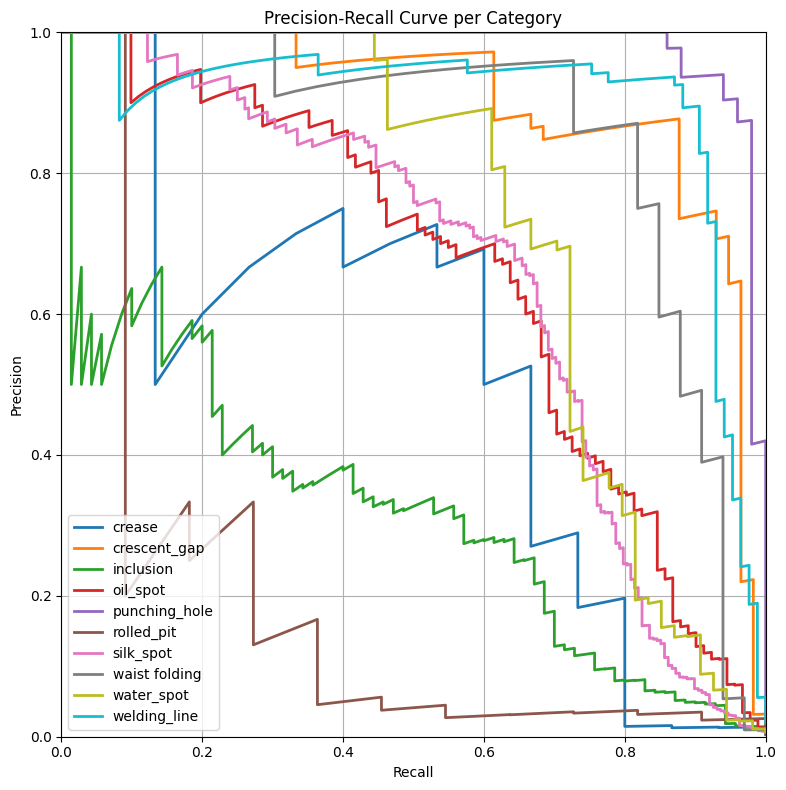

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import defaultdict
from sklearn.metrics import precision_recall_curve

truth_json = 'datasets/GC10-Det/valid/ann/annotations.json'
pred_json = 'workdirs/inference/coco_2017_val/bbox.json'
# Load COCO GT and prediction JSONs
coco_gt = COCO(truth_json)
with open(pred_json, 'r') as f:
    predictions = json.load(f)

# Get category ID to name mapping
categories = coco_gt.loadCats(coco_gt.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
cat_ids = list(cat_id_to_name.keys())

# Group predictions by category
preds_by_cat = defaultdict(list)
for pred in predictions:
    preds_by_cat[pred['category_id']].append(pred)

# Group GT annotations by category
gt_by_cat = defaultdict(list)
for ann in coco_gt.dataset['annotations']:
    gt_by_cat[ann['category_id']].append(ann)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

iou_threshold = 0.5
class_curves = {}

for cat_id in cat_ids:
    cat_id = cat_id
    y_true = []
    y_scores = []

    preds = sorted(preds_by_cat[cat_id], key=lambda x: -x['score'])
    gt_annots = gt_by_cat[cat_id]
    used = set()

    for pred in preds:
        pred_box = pred['bbox']
        image_id = pred['image_id']
        matched = False

        for gt in gt_annots:
            if gt['image_id'] != image_id or gt['id'] in used:
                continue
            iou = compute_iou(pred_box, gt['bbox'])
            if iou >= iou_threshold:
                matched = True
                used.add(gt['id'])
                break

        y_true.append(1 if matched else 0)
        y_scores.append(pred['score'])

    if len(set(y_true)) < 2:
        if sum(y_true) == 0:
            print(f"Class {cat_id_to_name[cat_id]} has ALL FALSE POSITIVES (no TP).")
        else:
            print(f"Class {cat_id_to_name[cat_id]} has ALL TRUE POSITIVES (no FP).")
        continue

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    class_curves[cat_id] = {
        'precision': precision,
        'recall': recall
    }

# Plotting Precision-Recall curves
plt.figure(figsize=(10, 8))
for cat_id, data in class_curves.items():
    plt.plot(data['recall'], data['precision'], label=cat_id_to_name[cat_id], linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Category')
plt.grid(True)
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig('precision_recall_curves.png', bbox_inches='tight', dpi=300)
plt.show()

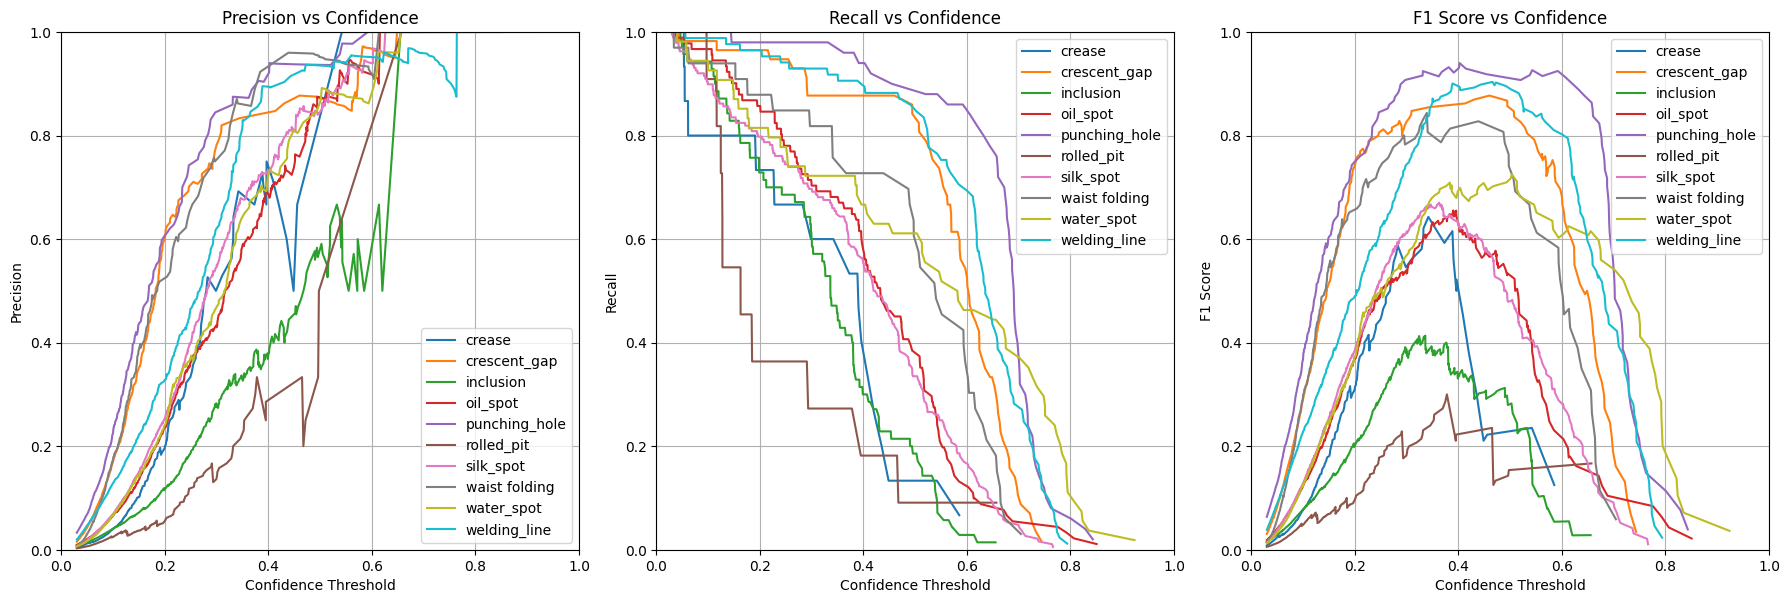

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import defaultdict
from sklearn.metrics import precision_recall_curve

# Load annotations and predictions
truth_json = 'datasets/GC10-Det/valid/ann/annotations.json'
pred_json = 'workdirs/inference/coco_2017_val/bbox.json'

# Load COCO GT and prediction JSONs
coco_gt = COCO(truth_json)
with open(pred_json, 'r') as f:
    predictions = json.load(f)

# Get category ID to name mapping
categories = coco_gt.loadCats(coco_gt.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
cat_ids = list(cat_id_to_name.keys())

# Group predictions by category
preds_by_cat = defaultdict(list)
for pred in predictions:
    preds_by_cat[pred['category_id']].append(pred)

# Group GT annotations by category
gt_by_cat = defaultdict(list)
for ann in coco_gt.dataset['annotations']:
    gt_by_cat[ann['category_id']].append(ann)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

iou_threshold = 0.5
class_curves = {}

for cat_id in cat_ids:
    y_true = []
    y_scores = []

    preds = sorted(preds_by_cat[cat_id], key=lambda x: -x['score'])
    gt_annots = gt_by_cat[cat_id]
    used = set()

    for pred in preds:
        pred_box = pred['bbox']
        image_id = pred['image_id']
        matched = False

        for gt in gt_annots:
            if gt['image_id'] != image_id or gt['id'] in used:
                continue
            iou = compute_iou(pred_box, gt['bbox'])
            if iou >= iou_threshold:
                matched = True
                used.add(gt['id'])
                break

        y_true.append(1 if matched else 0)
        y_scores.append(pred['score'])

    if len(set(y_true)) < 2:
        if sum(y_true) == 0:
            print(f"Class {cat_id_to_name[cat_id]} has ALL FALSE POSITIVES (no TP).")
        else:
            print(f"Class {cat_id_to_name[cat_id]} has ALL TRUE POSITIVES (no FP).")
        continue

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    class_curves[cat_id] = {
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds
    }

# Plotting
plt.figure(figsize=(18, 6))

# 1. Precision-Confidence
plt.subplot(1, 3, 1)
for cat_id, data in class_curves.items():
    plt.plot(data['thresholds'], data['precision'][:-1], 
             label=cat_id_to_name[cat_id])
plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 2. Recall-Confidence
plt.subplot(1, 3, 2)
for cat_id, data in class_curves.items():
    plt.plot(data['thresholds'], data['recall'][:-1], 
             label=cat_id_to_name[cat_id])
plt.xlabel('Confidence Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 3. NEW: F1-Confidence
plt.subplot(1, 3, 3)
for cat_id, data in class_curves.items():
    # Calculate F1 scores
    precision = data['precision'][:-1]
    recall = data['recall'][:-1]
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    plt.plot(data['thresholds'], f1_scores, 
             label=cat_id_to_name[cat_id])

plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.tight_layout()
#plt.savefig('precision_recall_f1_confidence.png', bbox_inches='tight', dpi=300)
plt.show()


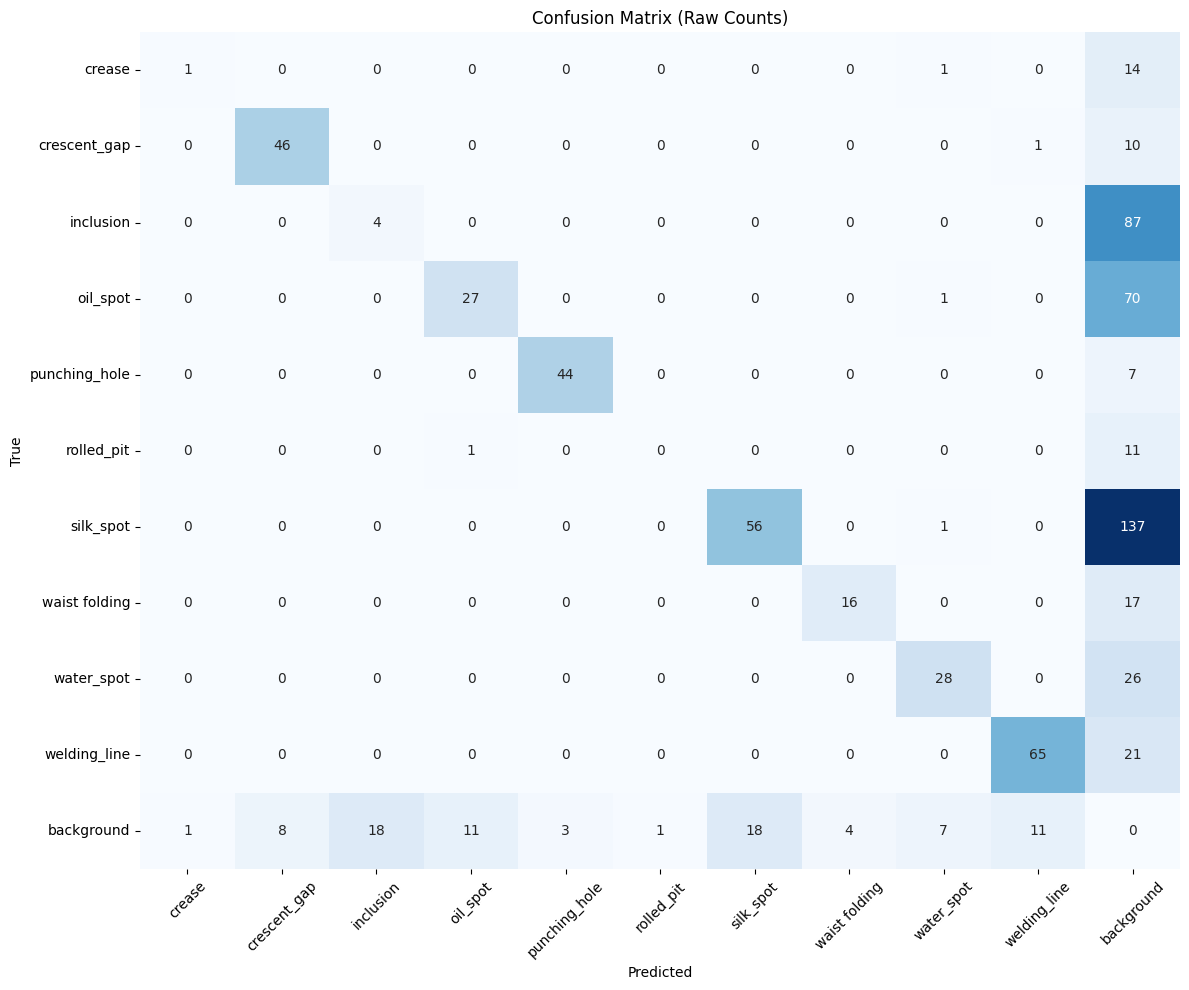

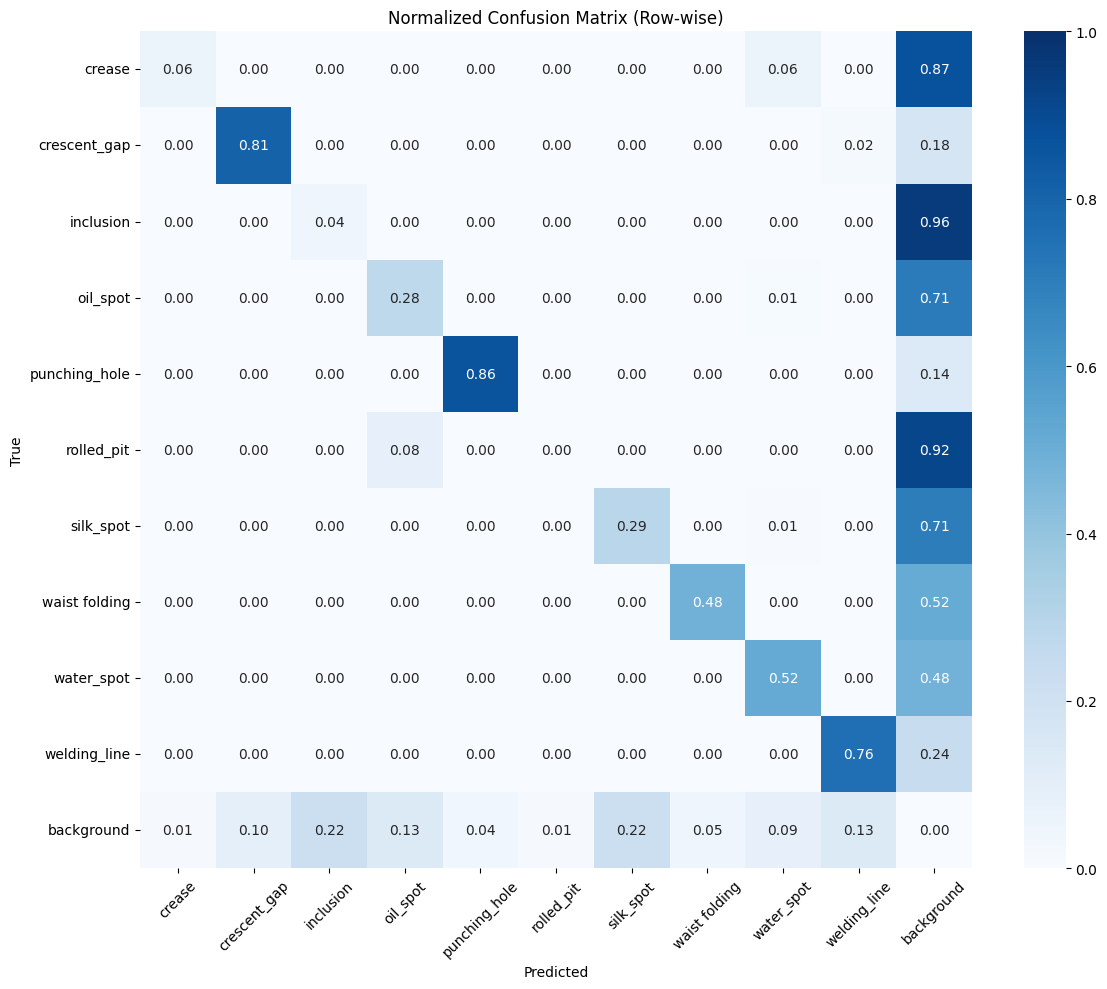

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycocotools import mask as maskUtils
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import confusion_matrix
from collections import defaultdict

# Load ground truth and predictions
truth_json = 'datasets/GC10-Det/valid/ann/annotations.json'
pred_json = 'workdirs/inference/coco_2017_val/bbox.json'

# Load COCO API for ground truth
coco_gt = COCO(truth_json)

# Load the original predictions
with open(pred_json) as f:
    pred_data = json.load(f)
    
# filter out low confidence
threshold = 0.5
filtered_data = [pred_data_t for pred_data_t in pred_data if pred_data_t['score']>=threshold]
coco_dt = coco_gt.loadRes(filtered_data)

class_names = [coco_gt.loadCats(ids)[0]['name'] for ids in coco_gt.getCatIds()]
num_classes = len(class_names)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

def compute_confusion_matrix(coco_gt, coco_dt, iou_thresh=0.65):
    """
    Compute confusion matrix with IoU matching
    Returns: (raw_confusion_matrix, normalized_confusion_matrix)
    """
    num_classes = len(coco_gt.getCatIds())
    cm = np.zeros((num_classes+1, num_classes+1), dtype=int)  # +1 for background/FP
    
    for img_id in coco_gt.getImgIds():
        gt_anns = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=img_id))
        dt_anns = coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=img_id))
        
        # Track which GT boxes have been matched
        matched_gt = [False] * len(gt_anns)
        
        # Process detections sorted by confidence (highest first)
        dt_anns = sorted(dt_anns, key=lambda x: -x['score'])
        
        for dt in dt_anns:
            best_iou = iou_thresh
            best_idx = -1
            
            # Find best matching GT
            for i, gt in enumerate(gt_anns):
                if not matched_gt[i]:
                    iou = compute_iou(dt['bbox'], gt['bbox'])
                    if iou > best_iou:
                        best_iou = iou
                        best_idx = i
            
            if best_idx >= 0:  # True positive (of at least there is object, despite of classes)
                matched_gt[best_idx] = True
                gt_class = gt_anns[best_idx]['category_id']  
                dt_class = dt['category_id']   
                cm[gt_class, dt_class] += 1
            else:  # False positive
                dt_class = dt['category_id'] 
                cm[-1, dt_class] += 1  # Last row is for FP
        
        # Any unmatched GT are false negatives
        for i, matched in enumerate(matched_gt):
            if not matched:
                gt_class = gt_anns[i]['category_id'] 
                cm[gt_class, -1] += 1  # Last column is for FN
    
    # Normalized version (row-wise)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)
    
    return cm, cm_norm

# Compute matrices
cm_raw, cm_norm = compute_confusion_matrix(coco_gt, coco_dt)
class_names_with_bg = class_names + ['background']
# Plot raw confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_raw, annot=True, fmt='d', 
            xticklabels=class_names_with_bg, yticklabels=class_names_with_bg,
            cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Raw Counts)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('confusion_matrix_raw.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', 
            xticklabels=class_names_with_bg, yticklabels=class_names_with_bg,
            cmap='Blues', vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix (Row-wise)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()
